In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

from math import comb
from scipy.stats import norm

# Creating the class

In [2]:
class Option:
    '''
    This class includes different pricing methods for the Vanilla and Digital Options
    
    Methods:
    - price_analytical()
    - price_mc()
    - price_binomial()
    - price()
    '''

    def __init__(self, spot, strike, vol, rate, maturity, payoff, method, 
                 payment=1.0, paths=1e3, dt_step=1.0/252.0, 
                 variance_reduction='None', option_type='Digital', confidence=0.975):

        # Setup the generic option parameters
        self.S = spot
        self.K = strike
        self.vol = vol
        self.r = rate
        self.T = maturity
        self.payoff = payoff
        self.method = method
        self.payment = payment
        self.N = int(paths)
        self.variance_reduction = variance_reduction
        self.option_type = option_type
        
        # Setup Binomial Tree parameters
        self.dt = self.T / self.N
        self.u = np.exp(self.vol * np.sqrt(self.dt))
        self.d = 1.0 / self.u
        self.q = (np.exp(self.r * self.dt) - self.d) / (self.u - self.d)
        
        # Setup the Monte Carlo pricing parameters
        if variance_reduction == 'None':
            self.N_adj = int(self.N)
        elif variance_reduction == 'Antithetic':
            self.N_adj = int(self.N // 2.0)

        self.dt_step = dt_step
        self.M = int(self.T / self.dt_step)
        self.confidence = confidence
        
        
    def price_analytical(self): 
        '''
        This function creates the price using the Black-Scholes analytical framework
        
        Args:
        - S (float) - spot price
        - K (float) - strike price
        - r (float) - funding rate
        - T (float) - maturity of the option
        - vol (float) - volatility of the stock price
        - payoff (str) - payoff of the option: Call or Put
        
        Outputs:
        - price (float) - price of the option
        '''
        
        self.d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.vol**2)*self.T)/\
                                                                (self.vol*np.sqrt(self.T))
        self.d2 = self.d1 - self.vol * np.sqrt(self.T)
        self.df = np.exp(-self.r * self.T)
        
        if self.payoff == 'Call':
            return self.payment * self.df * norm.cdf(self.d2) 
        elif self.payoff == 'Put':
            return self.payment * self.df * norm.cdf(-self.d2)
        else:
            print('Choose correct payoff: Call, Put')
            
            
    def price_mc(self):

        '''
        This function creates the price using the standard Monte-Carlo pricing method as well as
        Monte-Carlo method with antithetic variables
        
        Args:
        - N (int) - number of simulations
        - M (int) - number of steps
        - S (float) - spot price
        - K (float) - strike price
        - r (float) - funding rate
        - vol (float) - volatility of the stock price
        - variance_reduction(str) - type of method for variance reduction
        
        Outputs:
        - price (float) - price of the option
        '''
                
        if self.variance_reduction == 'None':
            S_t = np.zeros((self.N_adj + 1, self.M + 1))
            S_t[:, 0] = self.S
            C_t = np.zeros(self.N_adj + 1)
            
            for j in range(self.N_adj + 1):
                for k in range(1, self.M + 1):
                    z_i = np.random.normal(0, 1, 1)
                    S_t[j, k] = S_t[j, k-1] * (1 + self.r * self.dt_step + self.vol * \
                                               np.sqrt(self.dt_step) * z_i)

            if self.payoff == 'Call':
                for j in range(self.N_adj):
                    C_t[j] = self.payment if S_t[j, self.M] >= self.K else 0

            elif self.payoff == 'Put':
                for j in range(self.N_adj):
                    C_t[j] = self.payment if S_t[j, self.M] <= self.K else 0

            else:
                print('Choose correct payoff: Call, Put')
                    
        elif self.variance_reduction == 'Antithetic':
            S_t_plus = np.zeros((self.N_adj + 1, self.M + 1))
            S_t_minus = np.zeros((self.N_adj + 1, self.M + 1))
            
            S_t_plus[:, 0] = self.S
            S_t_minus[:, 0] = self.S
            
            C_t_plus = np.zeros(self.N_adj + 1)
            C_t_minus = np.zeros(self.N_adj + 1)
            
            for j in range(self.N_adj + 1):
                for k in range(1, self.M + 1):
                    z_i = np.random.normal(0, 1, 1)
                    S_t_plus[j, k] = S_t_plus[j, k-1] * (1 + self.r * self.dt_step + \
                                                         self.vol * np.sqrt(self.dt_step) * z_i)
                    S_t_minus[j, k] = S_t_minus[j, k-1] * (1 + self.r * self.dt_step + \
                                     self.vol * np.sqrt(self.dt_step) * (-z_i))
            
            if self.payoff == 'Call':
                for j in range(self.N_adj):
                    C_t_plus[j] = self.payment if S_t_plus[j, self.M] >= self.K else 0
                    C_t_minus[j] = self.payment if S_t_minus[j, self.M] >= self.K else 0


            elif self.payoff == 'Put':
                for j in range(self.N_adj):
                    C_t_plus[j] = self.payment if S_t_plus[j, self.M] <= self.K else 0
                    C_t_minus[j] = self.payment if S_t_minus[j, self.M] <= self.K else 0

            else:
                print('Choose correct payoff: Call, Put')
            
            C_t = 0.5 * (C_t_plus + C_t_minus)
            
        else:
            print('Choose correct method for variance reduction: None or Antithetic')
        
        price = np.mean(C_t) * np.exp(-self.r * self.T)
        std = np.std(C_t * np.exp(-self.r * self.T))
        
        ci_lower = price - norm.ppf(self.confidence) * std / np.sqrt(self.N_adj)
        ci_upper = price + norm.ppf(self.confidence) * std / np.sqrt(self.N_adj)
        
        return price, std, ci_lower, ci_upper
    
    
    def price_binomial(self):
        '''
        This function creates the price using the standard Binomial Tree pricing method
        
        Args:
        - N (int) - number of steps
        - S (float) - spot price
        - K (float) - strike price
        - u (float) - probability of up-move
        - d (float) - probability of down-move
        - r (float) - funding rate
        - vol (float) - volatility of the stock price
        - q (float) - risk-neutral probability
        
        Outputs:
        - price (float) - price of the option
        '''
        
        S_t = np.zeros((self.N + 1, self.N + 1))
        
        # Generate stock prices path
        for i in range(self.N + 1):
            for j in range(self.N + 1):
                S_t[j, i] = self.S * self.u**(i-j) * self.d**j
                
        # Generate array for options prices
        C_t = np.zeros((self.N + 1, self.N + 1))
        
        # Generate payoff 
        if self.payoff == 'Call':
            C_t[:, self.N] = [self.payment if S_t_i >= self.K else 0.0 for S_t_i in S_t[:, self.N]]
        elif self.payoff == 'Put':
            C_t[:, self.N] = [self.payment if S_t_i <= self.K else 0.0 for S_t_i in S_t[:, self.N]]
        else:
            print('Choose correct payoff: Call, Put')
        
        # Recursively calculate the options price
        for t in range(self.N):
            for j in range(self.N):
                C_t[j, self.N - t - 1] = np.exp(-self.r * self.dt) * (self.q * C_t[j, self.N - t] + \
                                                                     (1 - self.q) * C_t[j + 1, self.N - t])
        price = C_t[0, 0] 
            
        return price
    
    def price(self):
        '''
        This function returns the price of the option, given the chosen calculation method
        
        Args:
        - None
        
        Outputs:
        - price (float) - price of the option
        '''
        
        if self.method == 'Analytical':
            price = self.price_analytical()
            
        elif self.method == 'MonteCarlo':
            price = self.price_mc()
            
        elif self.method == 'Binomial':
            price = self.price_binomial()
                                
        else:
            print('Choose correct pricing method: Analytical, MonteCarlo, Binomial')
            
        return np.round(price, 4)

# Checking the results

## vs Binomial

In [3]:
# Here is the analytical price for the Digital option
price_analytical = Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
       payoff='Call', method='Analytical', payment=1.0).price()

print('This is the analytical price of Digital Call: ', price_analytical)

This is the analytical price of Digital Call:  0.4341


In [4]:
# This is the behavior of the option price with repsect to number of nodes

prices_binomial = []


for n in range(1, 300):
    price = Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
                   payoff='Call', method='Binomial', payment=1.0, paths=n).price()
    
    prices_binomial.append(price)

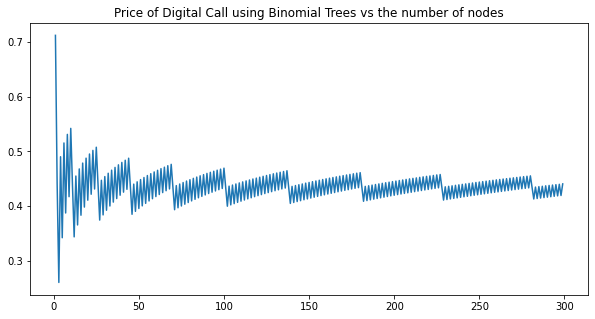

In [5]:
plt.figure(figsize=(10, 5));
plt.plot(range(1, 300), prices_binomial);
plt.title('Price of Digital Call using Binomial Trees vs the number of nodes');

In [6]:
# Let's plot the value of the option using binomial model and find N' for which price is 1 cent away from 
# analytical one

prices_binomial = []

price_diverge = True

n = 1

while price_diverge:
    price = Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
                   payoff='Call', method='Binomial', payment=1.0, paths=n).price()
    
    prices_binomial.append(price)
    print(f'Price analytical {price_analytical}, price binomial {price}')
    
    if np.abs(price_analytical - price) < 0.01:
        price_diverge = False
        print('The break-even N is ', n)
    
    n += 1

Price analytical 0.4341, price binomial 0.7124
Price analytical 0.4341, price binomial 0.4407
The break-even N is  2


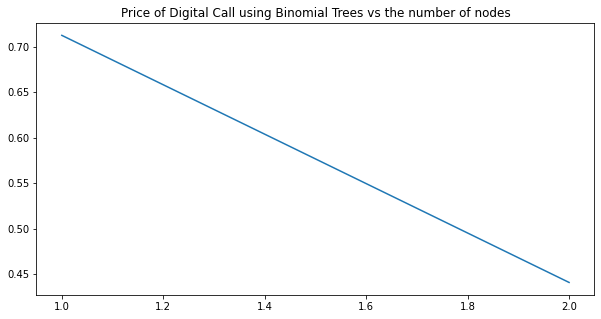

In [7]:
plt.figure(figsize=(10, 5));
plt.plot(range(1, n), prices_binomial);
plt.title('Price of Digital Call using Binomial Trees vs the number of nodes');

## vs Monte Carlo

In [15]:
prices_mc_standard = []

price_diverge = True

n = 30000

while price_diverge:
    print(n)
    price, std, ci_lower, ci_upper = Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
                   payoff='Call', method='MonteCarlo', payment=1.0, paths=n).price()
    
    prices_mc_standard.append(price)
    
    print(f'Price analytical {price_analytical}, price binomial {price}, Lower CI {ci_lower}, Upper CI {ci_upper}')
    
    if (ci_upper - ci_lower) <= 0.01:
        price_diverge = False
        print('The break-even N is ', n)
    
    n += 1000

30000
Price analytical 0.4341, price binomial 0.4359, Lower CI 0.4308, Upper CI 0.441
31000
Price analytical 0.4341, price binomial 0.4365, Lower CI 0.4315, Upper CI 0.4416
32000
Price analytical 0.4341, price binomial 0.4359, Lower CI 0.4309, Upper CI 0.4408
The break-even N is  32000


In [8]:
# Let's check the standard errors
Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
                   payoff='Call', method='MonteCarlo', payment=1.0, paths=1000).price()

array([0.4303, 0.4519, 0.4023, 0.4583])

In [9]:
# And check for antithetic variables
prices_mc_antithetic = []

price_diverge = True

n = 1000

while price_diverge:
    print(n)
    price, std, ci_lower, ci_upper = Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
                                            payoff='Call', method='MonteCarlo', 
                                            variance_reduction='Antithetic',
                                            payment=1.0, paths=n).price()
    
    prices_mc_antithetic.append(price)
    
    print(f'Price analytical {price_analytical}, price binomial {price}, Lower CI {ci_lower}, Upper CI {ci_upper}')
    
    if (ci_upper - ci_lower) <= 0.01:
        price_diverge = False
        print('The break-even N is ', n)
    
    n += 100

1000
Price analytical 0.4341, price binomial 0.4362, Lower CI 0.4288, Upper CI 0.4435
1100
Price analytical 0.4341, price binomial 0.436, Lower CI 0.4289, Upper CI 0.4431
1200
Price analytical 0.4341, price binomial 0.4396, Lower CI 0.4336, Upper CI 0.4456
1300
Price analytical 0.4341, price binomial 0.4378, Lower CI 0.4317, Upper CI 0.444
1400
Price analytical 0.4341, price binomial 0.4356, Lower CI 0.4293, Upper CI 0.442
1500
Price analytical 0.4341, price binomial 0.4349, Lower CI 0.4287, Upper CI 0.4412
1600
Price analytical 0.4341, price binomial 0.4343, Lower CI 0.4282, Upper CI 0.4405
1700
Price analytical 0.4341, price binomial 0.4338, Lower CI 0.4278, Upper CI 0.4399
1800
Price analytical 0.4341, price binomial 0.4318, Lower CI 0.4257, Upper CI 0.438
1900
Price analytical 0.4341, price binomial 0.431, Lower CI 0.4249, Upper CI 0.4371
2000
Price analytical 0.4341, price binomial 0.4334, Lower CI 0.4278, Upper CI 0.4391
2100
Price analytical 0.4341, price binomial 0.4348, Lower 

In [10]:
Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
        payoff='Call', method='MonteCarlo', 
        variance_reduction='Antithetic',
        payment=1.0, paths=1000).price()

array([0.4262, 0.1057, 0.417 , 0.4355])

# Measuring the computational complexity

In [16]:
%%timeit

Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
                   payoff='Call', method='Binomial', payment=1.0, paths=2).price()

29.3 µs ± 390 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
                   payoff='Call', method='Binomial', payment=1.0, paths=2).price()

0.4407

In [11]:
%%timeit

Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
        payoff='Call', method='MonteCarlo', 
        variance_reduction='None',
        payment=1.0, paths=2000).price()

3.62 s ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
        payoff='Call', method='MonteCarlo', 
        variance_reduction='None',
        payment=1.0, paths=2000).price()

array([0.4427, 0.4523, 0.4229, 0.4625])

In [13]:
%%timeit

Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
        payoff='Call', method='MonteCarlo', 
        variance_reduction='Antithetic',
        payment=1.0, paths=2000).price()

2.99 s ± 49.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
Option(spot=100, strike=110, vol=0.16, rate=0.1, maturity=1.0, 
        payoff='Call', method='MonteCarlo', 
        variance_reduction='Antithetic',
        payment=1.0, paths=2000).price()

array([0.433 , 0.0917, 0.4273, 0.4387])